# Course 2 - 改善深层神经网络 - 第一周作业(2) - 正则化
1. 初始化参数：
	* 使用0来初始化参数。
	* 使用随机数来初始化参数。
	* 使用抑梯度异常初始化参数（参见视频中的梯度消失和梯度爆炸）。
2. 正则化模型：
	* 使用二范数对二分类模型正则化，尝试避免过拟合。 (`L2正则化`)
	* 使用随机删除节点的方法精简模型，同样是为了尝试避免过拟合。(`dropout正则化`)
3. 梯度校验  ：对模型使用梯度校验，检测它是否在梯度下降的过程中出现误差过大的情况。

在深度学习中，如果数据集没有足够大的话，可能会导致一些过拟合的问题。过拟合导致的结果就是在训练集上有着很高的精确度，但是在遇到新的样本时，精确度下降会很严重。为了避免过拟合的问题，接下来我们要讲解的方式就是正则化。


## 正则化模型
> Problem Statement: You have just been hired as an AI expert by the French Football Corporation. They would like you to recommend positions where France’s goal keeper should kick the ball so that the French team’s players can then hit it with their head.

问题描述：假设你现在是一个AI专家，你需要设计一个模型，可以用于推荐在足球场中守门员将球发至哪个位置可以让本队的球员抢到球的可能性更大。说白了，实际上就是一个二分类，一半是己方抢到球，一半就是对方抢到球，我们来看一下这个图：
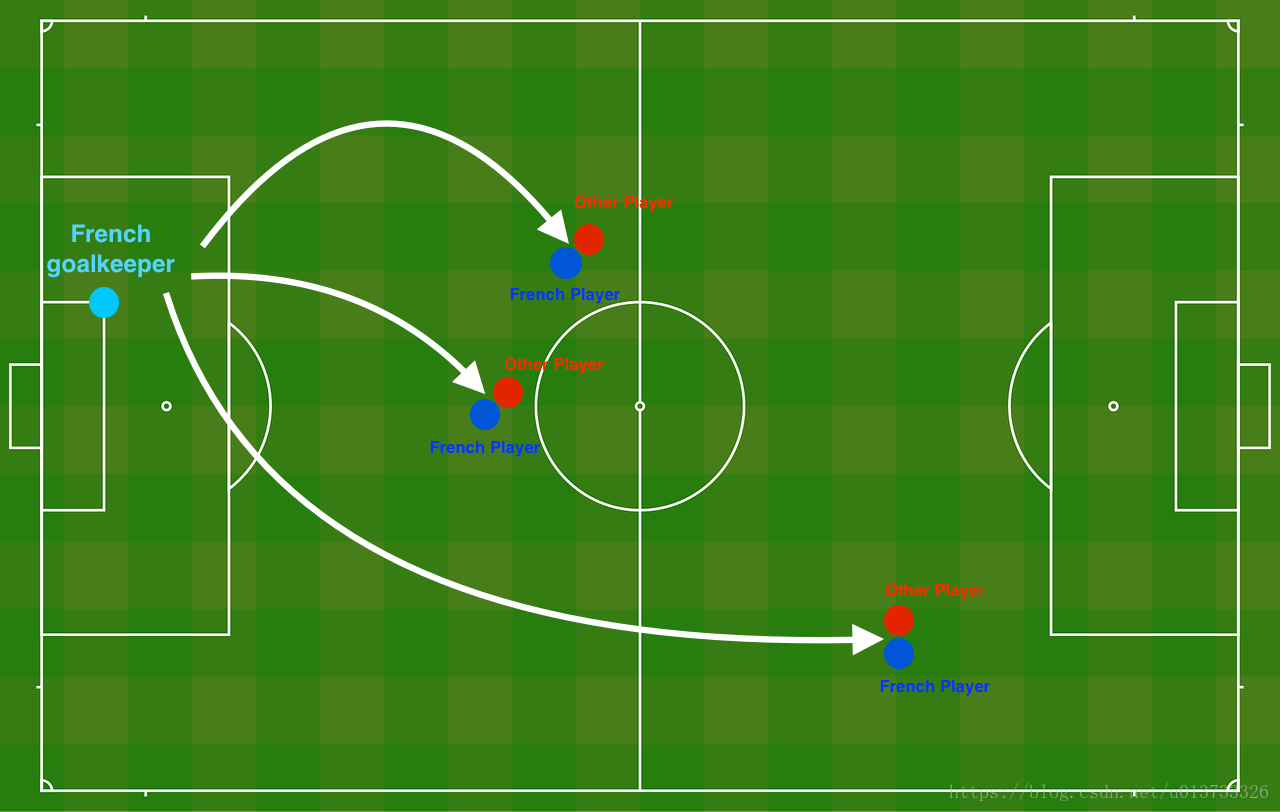

## 导入相关库

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import reg_utils    #第二部分，正则化
%matplotlib inline

plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## 读取并绘制数据集

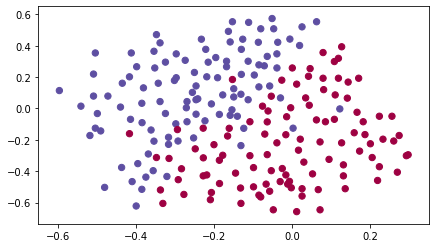

In [2]:
# 加载并查看数据集
train_X, train_Y, test_X, test_Y = reg_utils.load_2D_dataset(is_plot=True)

每一个点代表球落下的可能的位置，蓝色代表己方的球员会抢到球，红色代表对手的球员会抢到球，我们要做的就是使用模型来画出一条线，来找到适合我方球员能抢到球的位置。

---
我们要做以下对比，来对比出不同的模型的优劣：
1. 不使用正则化

2. 使用正则化
        2.1 使用L2正则化
        2.2 使用随机节点删除

## 模型
* L2正则化模式：将`lambd`输入设置为非零值
* 随机删除节点(dropout): 将`keep_prob`设置为小于1的值

In [3]:
def model(X, Y, learning_rate = 0.3, num_iterations = 30000, print_cost = True, is_plot = True, lambd = 0, keep_prob = 1):
    """
    实现一个三层的神经网络：LINEAR ->RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    参数：
        X - 输入的数据，维度为(2, 要训练/测试的数量)
        Y - 标签，【0(蓝色) | 1(红色)】，维度为(1，对应的是输入的数据的标签)
        learning_rate - 学习速率
        num_iterations - 迭代的次数
        print_cost - 是否打印成本值，每迭代10000次打印一次，但是每1000次记录一个成本值
        is_polt - 是否绘制梯度下降的曲线图
        lambd - L2正则化的超参数，实数
        keep_prob - 随机删除节点的概率
    返回：
        parameters - 学习后的参数
    """
    grads = {}
    costs = []
    m = X.shape[1]
    layers_dims = [X.shape[0], 20, 3, 1]
    
    # 初始化参数
    parameters = reg_utils.initialize_parameters(layers_dims)
    
    # 开始学习
    for i in range(0, num_iterations):
        # 向前传播
        ## 是否随机删除节点
        if keep_prob == 1:
            ### 不随机删除节点
            a3, cache = reg_utils.forward_propagation(X, parameters)
        elif keep_prob < 1:
            ### 随机删除节点
            a3, cache = forward_propagation_with_dropout(X,parameters,keep_prob)
        else:
            print("keep_prob参数错误！程序退出。")
            exit
        
        # 计算成本
        ## 是否使用L2正则化
        if lambd == 0:
            ### 不适用L2正则化
            cost = reg_utils.compute_cost(a3, Y)
        else:
            ### 使用L2正则化
            cost = compute_cost_with_regularization(a3,Y,parameters,lambd)
        
        # 反向传播
        ## 本次实验不同时使用L2正则化和dropout正则化
        assert(lambd == 0  or keep_prob ==1)
        
        ## 两个参数的使用情况
        if (lambd == 0 and keep_prob == 1):
            ## 不使用L2正则化和不使用随机删除节点
            grads = reg_utils.backward_propagation(X, Y, cache)
        elif lambd != 0:
            ## 使用L2正则化，不使用随机删除节点
            grads = backward_propagation_with_regularization(X, Y, cache, lambd)
        elif keep_prob < 1:
            ### 使用随机删除节点，不使用L2正则化
            grads = backward_propagation_with_dropout(X, Y, cache, keep_prob)
        
        # 更新参数
        parameters = reg_utils.update_parameters(parameters, grads, learning_rate)
        
        #记录并打印成本
        if i % 1000 == 0:
            ## 记录成本
            costs.append(cost)
            if (print_cost and i % 10000 == 0):
                #打印成本
                print("第" + str(i) + "次迭代，成本值为：" + str(cost))
        
    #是否绘制成本曲线图
    if is_plot:
        plt.plot(costs)
        plt.ylabel('cost')
        plt.xlabel('iterations (x1,0000)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
    
    #返回学习后的参数
    return parameters

## 1. 不适用正则化

第0次迭代，成本值为：0.6557412523481002
第10000次迭代，成本值为：0.16329987525724196
第20000次迭代，成本值为：0.13851642423253843


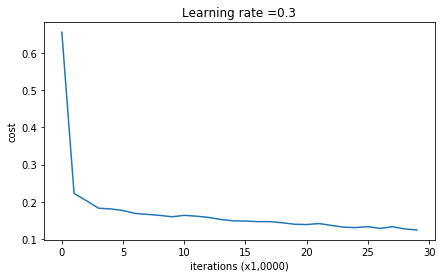

训练集:
Accuracy: 0.9478672985781991
测试集:
Accuracy: 0.915


In [4]:
parameters = model(train_X, train_Y,is_plot=True)
print("训练集:")
predictions_train = reg_utils.predict(train_X, train_Y, parameters)
print("测试集:")
predictions_test = reg_utils.predict(test_X, test_Y, parameters)

我们可以看到，对于训练集，精确度为94%；而对于测试集，精确度为91.5%。接下来，我们将分割曲线画出来：

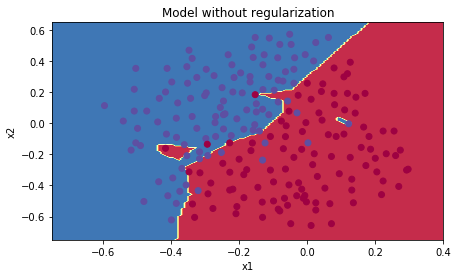

In [5]:
plt.title("Model without regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
reg_utils.plot_decision_boundary(lambda x: reg_utils.predict_dec(parameters, x.T), train_X, train_Y)

从图中可以看出，在无正则化时，分割曲线有了明显的过拟合特性。接下来，我们使用L2正则化：
## 2. 使用正则化
### 2.1 L2 正则化

避免过度拟合的标准方法称为L2正则化
1. 它包括适当修改你的成本函数，我们从原来的成本函数(1)到现在的函数(2)：
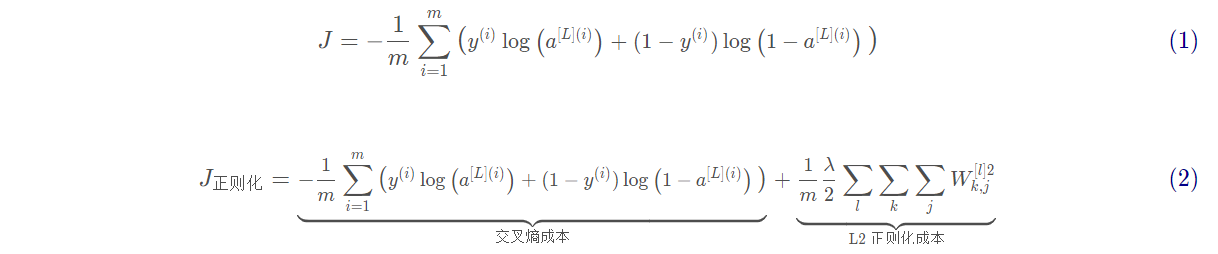
计算$\sum_k\sum_jW_{k,j}^{[l] 2}$的代码为：`np.sum(np.square(Wl))`

2. 后向传播中，`dW`的梯度计算修改为$dW^{[l]} = (from\ backprop) + \frac{\lambda}{m}W^{[l]}$

相关函数如下：

In [6]:
def compute_cost_with_regularization(A3,Y,parameters,lambd):
    """
    实现公式2的L2正则化计算成本
    参数：
        A3 - 正向传播的输出结果，维度为（输出节点数量，训练/测试的数量）
        Y - 标签向量，与数据一一对应，维度为(输出节点数量，训练/测试的数量)
        parameters - 包含模型学习后的参数的字典
    返回：
        cost - 使用公式2计算出来的正则化损失的值
    """
    m = Y.shape[1]
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    W3 = parameters["W3"]
    
    cross_entropy_cost = reg_utils.compute_cost(A3,Y)
    L2_regularization_cost = lambd * (np.sum(np.square(W1)) + np.sum(np.square(W2)) + np.sum(np.square(W3))) / (2 * m)
    cost = cross_entropy_cost + L2_regularization_cost
    
    return cost

#当然，因为改变了成本函数，我们也必须改变向后传播的函数， 所有的梯度都必须根据这个新的成本值来计算。
def backward_propagation_with_regularization(X, Y, cache, lambd):
    """
    实现我们添加了L2正则化的模型的后向传播。
    参数：
        X - 输入数据集，维度为（输入节点数量，数据集里面的数量）
        Y - 标签，维度为（输出节点数量，数据集里面的数量）
        cache - 来自forward_propagation（）的cache输出
        lambda - regularization超参数，实数
    
    返回：
        gradients - 一个包含了每个参数、激活值和预激活值变量的梯度的字典
    """
    m = X.shape[1]
    
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    
    dW3 = (1 / m) * np.dot(dZ3,A2.T) + ((lambd * W3) / m )
    db3 = (1 / m) * np.sum(dZ3,axis=1,keepdims=True)
    
    dA2 = np.dot(W3.T,dZ3)
    dZ2 = np.multiply(dA2,np.int64(A2 > 0))
    dW2 = (1 / m) * np.dot(dZ2,A1.T) + ((lambd * W2) / m)
    db2 = (1 / m) * np.sum(dZ2,axis=1,keepdims=True)
    
    dA1 = np.dot(W2.T,dZ2)
    dZ1 = np.multiply(dA1,np.int64(A1 > 0))
    dW1 = (1 / m) * np.dot(dZ1,X.T) + ((lambd * W1) / m)
    db1 = (1 / m) * np.sum(dZ1,axis=1,keepdims=True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3, "dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

第0次迭代，成本值为：0.6974484493131264
第10000次迭代，成本值为：0.2684918873282239
第20000次迭代，成本值为：0.2680916337127301


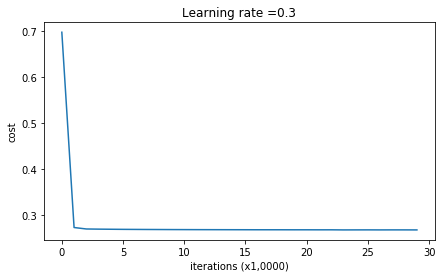

使用正则化，训练集:
Accuracy: 0.9383886255924171
使用正则化，测试集:
Accuracy: 0.93


In [7]:
parameters = model(train_X, train_Y, lambd=0.7,is_plot=True)
print("使用正则化，训练集:")
predictions_train = reg_utils.predict(train_X, train_Y, parameters)
print("使用正则化，测试集:")
predictions_test = reg_utils.predict(test_X, test_Y, parameters)

**查看分类结果：**

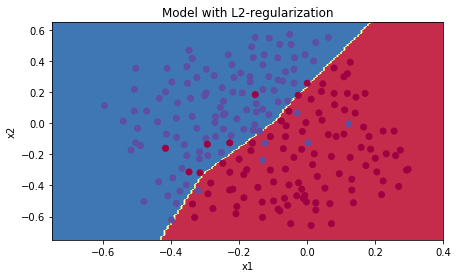

In [8]:
plt.title("Model with L2-regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
reg_utils.plot_decision_boundary(lambda x: reg_utils.predict_dec(parameters, x.T), train_X, train_Y)

`λ`的值是可以使用`dev set`调整时的超参数。如果λ太大，也可能会“过度平滑”，从而导致模型高偏差。

L2正则化实际上在做什么？L2正则化依赖于**较小权重的模型比具有较大权重的模型更简单**这样的假设，因此，通过**削减成本函数中权重的平方值**，可以将所有权重值逐渐改变到到较小的值。权值数值高的话会有更平滑的模型，其中输入变化时输出变化更慢，但是你需要花费更多的时间。L2正则化对以下内容有影响：
* 成本计算       ： 正则化的计算需要添加到成本函数中
* 反向传播功能     ：在权重矩阵方面，梯度计算时也要依据正则化来做出相应的计算
* 重量变小（“重量衰减”) ：权重被逐渐改变到较小的值。

### 2.2 随机删除节点 (`Dropout`)

最后，我们使用Dropout来进行正则化，Dropout的原理就是每次迭代过程中随机将其中的一些节点失效。当我们关闭一些节点时，我们实际上修改了我们的模型。背后的想法是，在每次迭代时，我们都会训练一个只使用一部分神经元的不同模型。随着迭代次数的增加，我们的模型的节点会对其他特定节点的激活变得不那么敏感，因为其他节点可能在任何时候会失效。

在每一次迭代中，神经元被删除的概率为$1 - keep\_prob$，保持的概率为$keep\_prob$（这里为50％）。删除的节点都不参与迭代时的前向和后向传播。
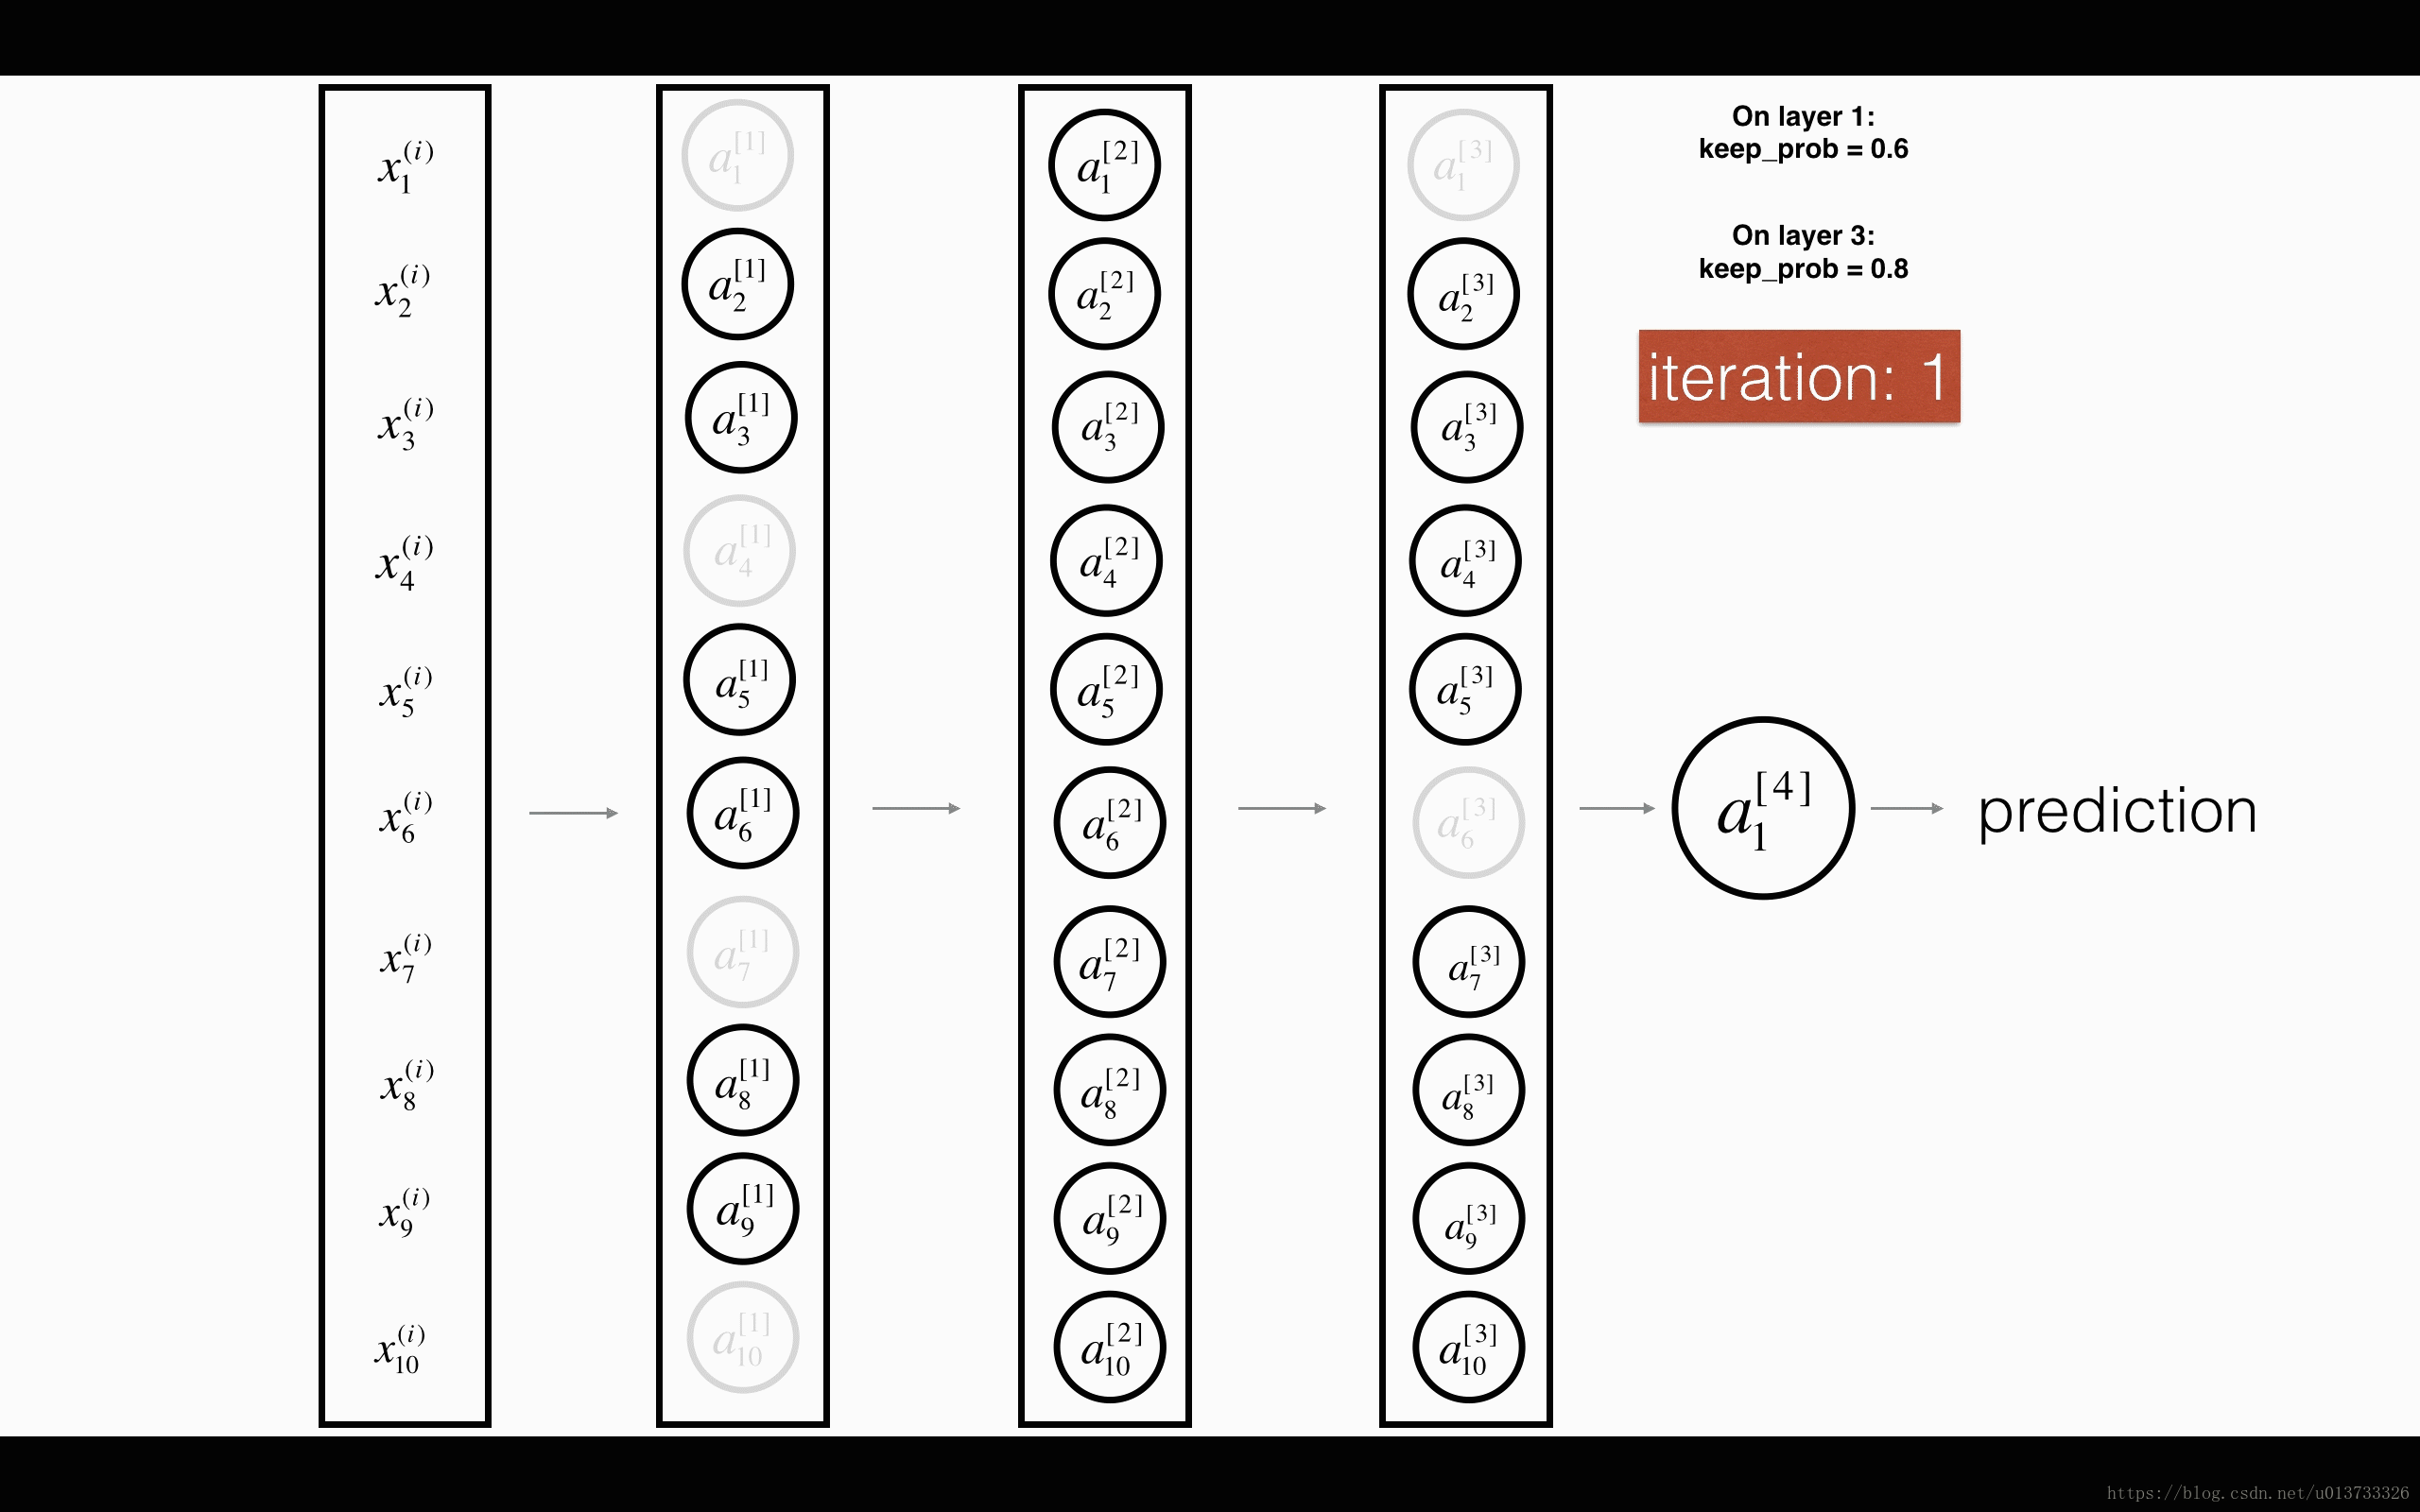

使用`dropout`,需要做以下4步：
1. 使用向量化，实现一个和$A^{[l]}$相同维度的随机矩阵$D^{[l]}$
2. 如果$D^{[l]}$低于 (keep_prob)的值我们就把它设置为0，如果高于(keep_prob)的值我们就设置为1。
3. 把$A^{[l]}$更新为￥$A^{[l]} * D^{[l]}$.做矩阵相乘的时候，关闭的那些节点（值为0）就会不参与计算，因为0乘以任何值都为0。
4. 使用$A^{[l]}$除以keep_prob 这样做的话我们通过缩放就在计算成本的时候仍然具有相同的期望值，这叫做反向dropout。

In [9]:
def forward_propagation_with_dropout(X,parameters,keep_prob=0.5):
    """
    实现具有随机舍弃节点的前向传播。
    LINEAR -> RELU + DROPOUT -> LINEAR -> RELU + DROPOUT -> LINEAR -> SIGMOID.
    参数：
        X  - 输入数据集，维度为（2，示例数）
        parameters - 包含参数“W1”，“b1”，“W2”，“b2”，“W3”，“b3”的python字典：
            W1  - 权重矩阵，维度为（20,2）
            b1  - 偏向量，维度为（20,1）
            W2  - 权重矩阵，维度为（3,20）
            b2  - 偏向量，维度为（3,1）
            W3  - 权重矩阵，维度为（1,3）
            b3  - 偏向量，维度为（1,1）
        keep_prob  - 随机删除的概率，实数
    返回：
        A3  - 最后的激活值，维度为（1,1），正向传播的输出
        cache - 存储了一些用于计算反向传播的数值的元组
    """
    np.random.seed(1)
    
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    #LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    Z1 = np.dot(W1, X) + b1
    A1 = reg_utils.relu(Z1)
    
    # 下面的步骤1-4对应于上述的步骤1-4
    D1 = np.random.rand(A1.shape[0],A1.shape[1])    #步骤1：初始化矩阵D1 = np.random.rand(..., ...)
    D1 = D1 < keep_prob                             #步骤2：将D1的值转换为0或1（使D1用keep_prob作为阈值）
    A1 = A1 * D1                                    #步骤3：舍弃A1的一些节点（将它的值变为0或False）
    A1 = A1 / keep_prob                             #步骤4：缩放未舍弃的节点(不为0)的值
    
    Z2 = np.dot(W2,A1) + b2
    A2 = reg_utils.relu(Z2)
    
    D2 = np.random.rand(A2.shape[0],A2.shape[1])    #步骤1：初始化矩阵D2 = np.random.rand(..., ...)
    D2 = D2 < keep_prob                             #步骤2：将D2的值转换为0或1（使D2用keep_prob作为阈值）
    A2 = A2 * D2                                    #步骤3：舍弃A2的一些节点（将它的值变为0或False）
    A2 = A2 / keep_prob                             #步骤4：缩放未舍弃的节点(不为0)的值
    
    Z3 = np.dot(W3, A2) + b3
    A3 = reg_utils.sigmoid(Z3)
    
    cache = (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3)
    
    return A3, cache

dropout的后向传播

In [10]:
def backward_propagation_with_dropout(X,Y,cache,keep_prob):
    """
    实现我们随机删除的模型的后向传播。
    参数：
        X  - 输入数据集，维度为（2，示例数）
        Y  - 标签，维度为（输出节点数量，示例数量）
        cache - 来自forward_propagation_with_dropout（）的cache输出
        keep_prob  - 随机删除的概率，实数
    返回：
        gradients - 一个关于每个参数、激活值和预激活变量的梯度值的字典
    """
    m = X.shape[1]
    (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 = 1./ m * np.dot(dZ3, A2.T)
    db3 = 1./ m * np.sum(dZ3, axis = 1, keepdims = True)
    dA2 = np.dot(W3.T, dZ3)
    
    dA2 = dA2 * D2          # 步骤1：使用正向传播期间相同的节点，舍弃那些关闭的节点（因为任何数乘以0或者False都为0或者False）
    dA2 = dA2 / keep_prob   # 步骤2：缩放未舍弃的节点(不为0)的值
    
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1./m * np.dot(dZ2, A1.T)
    db2 = 1./m * np.sum(dZ2, axis = 1, keepdims = True)
    dA1 = np.dot(W2.T, dZ2)
    
    dA1 = dA1 * D1
    dA1 = dA1 / keep_prob
    
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1./ m * np.dot(dZ1, X.T)
    db1 = 1./ m * np.sum(dZ1, axis = 1, keepdims = True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

第0次迭代，成本值为：0.6543912405149825


D:\360MoveData\Users\38004\Desktop\MyIPythonNotebook\Course2_改善深层神经网络\work1\reg_utils.py:121: RuntimeWarning: divide by zero encountered in log
  logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)
D:\360MoveData\Users\38004\Desktop\MyIPythonNotebook\Course2_改善深层神经网络\work1\reg_utils.py:121: RuntimeWarning: invalid value encountered in multiply
  logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)


第10000次迭代，成本值为：0.061016986574905605
第20000次迭代，成本值为：0.060582435798513114


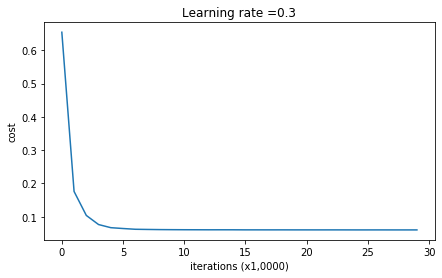

使用随机删除节点，训练集:
Accuracy: 0.9289099526066351
使用随机删除节点，测试集:
Accuracy: 0.95


In [11]:
parameters = model(train_X, train_Y, keep_prob=0.86, learning_rate=0.3,is_plot=True)

print("使用随机删除节点，训练集:")
predictions_train = reg_utils.predict(train_X, train_Y, parameters)
print("使用随机删除节点，测试集:")
reg_utils.predictions_test = reg_utils.predict(test_X, test_Y, parameters)

**查看分类情况**

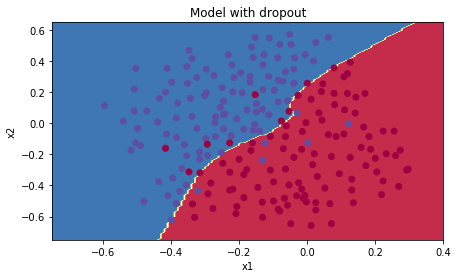

In [12]:
plt.title("Model with dropout")
axes = plt.gca()
axes.set_xlim([-0.75, 0.40])
axes.set_ylim([-0.75, 0.65])
reg_utils.plot_decision_boundary(lambda x: reg_utils.predict_dec(parameters, x.T), train_X, train_Y)

可以看到，正则化会把训练集的准确度降低，但是测试集的准确度提高了，所以，这个还是成功了。